
# Welcome to the IndabaX 2024 Guided Hackathon with Isazi!


## 1. Introduction
*********************************

#### 1.1. Problem Domain

In the fast-paced retail sector, understanding and predicting sales volumes is crucial for effective inventory management, pricing strategy, and promotional planning. Accurately forecasting sales not only optimizes operational efficiencies but also enhances customer satisfaction by ensuring product availability and competitive pricing.

#### 1.2 Challenge Description

Participants are tasked with developing a predictive model that forecasts the future sales volumes of various products based on historical sales data. The dataset provided includes daily sales figures, promotional activities, and pricing information. The primary objective is to predict the volume of product sales for upcoming dates, which is critical for managing supply chain and marketing strategies.

#### 1.3. Objectives
- **Feature Engineering**: Identify and harness the influence of promotional activities and pricing strategies on sales volumes.
- **Model Development**: Build robust time series forecasting models that can accurately predict sales volumes.

#### 1.4. Evaluation Criteria

The evaluation of forecasting models in this challenge uses two primary metrics: Overall Forecast Accuracy and Relative Bias. These metrics are calculated as follows:

1. **Total Sales Volume**: Sum the actual sales volumes across all time series to obtain the total actual volume.
2. **Total Predicted Volume**: Sum the predicted sales volumes across all time series.
3. **Total Error**: Compute the absolute error between predicted and actual sales volumes for each prediction, and then sum these errors across all time series.
4. **Relative Error**: Divide the total error by the total actual volume to obtain the relative error.
5. **Forecast Accuracy**: Calculate forecast accuracy as `1 - Relative Error`.
6. **Relative Bias**: Compute the relative bias by subtracting the total actual volume from the total predicted volume and dividing the result by the total actual volume. This metric indicates the tendency of the models to overestimate or underestimate the sales volumes.

These metrics ensure a comprehensive evaluation of model performance:
- **Forecast Accuracy** emphasizes the precision of individual predictions and is weighted towards time series with higher sales volumes, which are more significant for overall business performance.
- **Relative Bias** measures the overall tendency of the predictions to be higher or lower than actual values, providing insight into the systemic accuracy of the models.

Models will be judged not only on how accurately they predict sales volumes but also on how well they maintain balance, avoiding systematic overestimation or underestimation of sales.

#### 1.5. Usefulness of the Challenge

The solutions developed during this hackathon will help businesses:
- **Enhance Decision Making**: Improve inventory and pricing decisions by predicting demand more accurately.
- **Optimize Promotional Strategies**: Understand the impact of various promotional tactics on sales and adjust these strategies to maximize profitability.
- **Reduce Waste and Shortages**: Better demand forecasts lead to more efficient supply chain management, reducing both excess stock and product shortages.

#### 1.6. Outcome

This challenge offers participants the opportunity to apply machine learning techniques to a real-world problem, enhancing their skills in data manipulation, model building, and evaluation. The top-performing models could potentially be implemented in real retail environments, demonstrating the practical value of predictive analytics in business contexts.

#### 1.7. Support Channels
* SwapCard Hackathon Discussion Forum

#### 1.8. Mentor and Support
* Kilian Massa

#### 1.9. Submission Process
The evaluation of forecasting models in this competition focuses on two key metrics:
Overall Forecast Accuracy and Relative Bias.

### Let's get started!

## 0. Setup
****************************************************************

#### 0.1 Mounting Google Drive

Running this Notebook on Google Colab?

* If yes, run the next cell.
* If No, Skip to 0.3: Update working directory.

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### 0.2. Update Working Directory

In [54]:
import os
path = os.getcwd()
path

'/content'

In [55]:
!ls

drive  lightning_logs  my_predictions.csv  sample_data


#### 0.3. Install Necessary Packages

In [29]:
!pip install pandas "gluonts[mxnet, torch]"

In [30]:
%pip install -r /content/drive/MyDrive/hackathon_indabax/requirements.txt

#### 0.4 Import Packages

In [31]:
import json  # Standard library for working with JSON data

import pandas as pd  # Powerful data manipulation and analysis library
import numpy as np  # Library for numerical computations
np.bool = np.bool_
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations
import seaborn as sns  # Data visualization library based on matplotlib, provides a high-level interface for drawing attractive and informative statistical graphics

from sklearn.model_selection import train_test_split  # Utility for splitting the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler  # Utility for standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Metrics for evaluating the performance of a regression model

from gluonts.dataset.pandas import PandasDataset  # GluonTS utility for creating datasets from pandas dataframes
from gluonts.evaluation.backtest import make_evaluation_predictions  # Utility for generating evaluation predictions from a trained model
from gluonts.evaluation import Evaluator  # Utility for evaluating the performance of time series forecasting models

from gluonts.mx import SimpleFeedForwardEstimator, Trainer # GluonTS classes for creating and training a simple feed-forward neural network model


#### 0.5 Define Constants

In [50]:
# Dataset paths and column definitions
time_series_id_col = 'product_code'
date_col = 'sales_date'
target_col = 'volume'
freq = "1D"
prediction_length = 28
data_path = "/content/drive/MyDrive/hackathon_indabax/isazi_ts_dataset.csv"


## 2. Loading Data
*********************************

In [56]:
# Load the dataset
df = pd.read_csv(data_path)
# Display the first few rows of the dataset
df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,NaN,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,NaN,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,NaN,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,NaN,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,NaN,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,NaN,98


## 3. Data Preprocessing
********************************
In this section, we'll preprocess the data to make it suitable for modeling. This includes handling missing values, encoding categorical variables, and scaling numerical features.

The dataset consists of the following columns:
- `sales_date`: Date of the sales record.
- `volume`: Number of units sold.
- `rel_promo_price`: Relative promotional price.
- `is_promo`: Indicator if the item was on promotion.
- `is_single_price_promo`: Indicator if there was a single price promotion.
- `is_multibuy_promo`: Indicator if there was a multibuy promotion.
- `rsp`: Retail selling price.
- `planned_promo_vol`: Planned promotional volume.
- `product_code`: Unique product identifier.
"""

`NB`: all the promo covariates (is_promo, planned_promo_vol, rel_promo_price, is_multibuy_promo) are reported by the supplier, and the volume we are predicting is the volume sold by the retailer, i.e. the supplier is essentially giving us an estimate of the retailer's promotions.

In [62]:
# Data types and missing values
print("Data types and missing values:")
df.info()

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300768 entries, 0 to 300767
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             300768 non-null  int64  
 1   sales_date             300768 non-null  object 
 2   volume                 300768 non-null  float64
 3   rel_promo_price        300768 non-null  float64
 4   is_promo               300768 non-null  int64  
 5   is_single_price_promo  300768 non-null  int64  
 6   is_multibuy_promo      300768 non-null  int64  
 7   rsp                    300768 non-null  float64
 8   planned_promo_vol      300768 non-null  float64
 9   product_code           300768 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 22.9+ MB


In [63]:
# Check for missing values
print("Missing values:")
df.isnull().sum()

Missing values:


Unnamed: 0               0
sales_date               0
volume                   0
rel_promo_price          0
is_promo                 0
is_single_price_promo    0
is_multibuy_promo        0
rsp                      0
planned_promo_vol        0
product_code             0
dtype: int64

In [64]:
# Summary statistics
print("Summary statistics:")
df.describe()

Summary statistics:


,Unnamed: 0,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
count,300768.000000,300768.000000,300768.000000,300768.000000,300768.000000,300768.000000,300768.000000,300768.000000,300768.000000
mean,150383.500000,120.719591,0.874149,0.518715,0.015221,0.433071,54.571881,96.356648,196.837523
std,86824.387219,297.419634,0.131270,0.499650,0.122431,0.495501,30.016813,477.299407,113.669563
min,0.000000,0.000000,0.241200,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,75191.750000,30.000000,0.760300,0.000000,0.000000,0.000000,29.990000,0.000000,99.000000
50%,150383.500000,64.000000,0.926200,1.000000,0.000000,0.000000,47.771300,0.000000,197.000000
75%,225575.250000,132.000000,1.000000,1.000000,0.000000,1.000000,72.990000,92.268500,295.000000
max,300767.000000,32086.000000,1.000000,1.000000,1.000000,1.000000,249.990000,35945.472900,411.000000


In [65]:
#get unique product
print("Number of Unique Products:")
df['product_code'].unique().sum()

Number of Unique Products:


84666

In [66]:
# Convert 'sales_date' to datetime
df['sales_date'] = pd.to_datetime(df['sales_date'])
print("Dataset after data type conversions:")
df.dtypes

Dataset after data type conversions:


Unnamed: 0                        int64
sales_date               datetime64[ns]
volume                          float64
rel_promo_price                 float64
is_promo                          int64
is_single_price_promo             int64
is_multibuy_promo                 int64
rsp                             float64
planned_promo_vol               float64
product_code                      int64
dtype: object

In [67]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

print("Dataset after removing duplicates:")
df

Dataset after removing duplicates:


,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98


In [68]:
# Handle missing values (if any)
df.ffill()
df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98


In [69]:
df.fillna(0)
df['planned_promo_vol'] = df['planned_promo_vol'].fillna(0)
df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5
...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98


## 4. Exploratory Data Analysis (EDA)
********************************

Before building the model, it's essential to understand the data through exploratory data analysis (EDA).


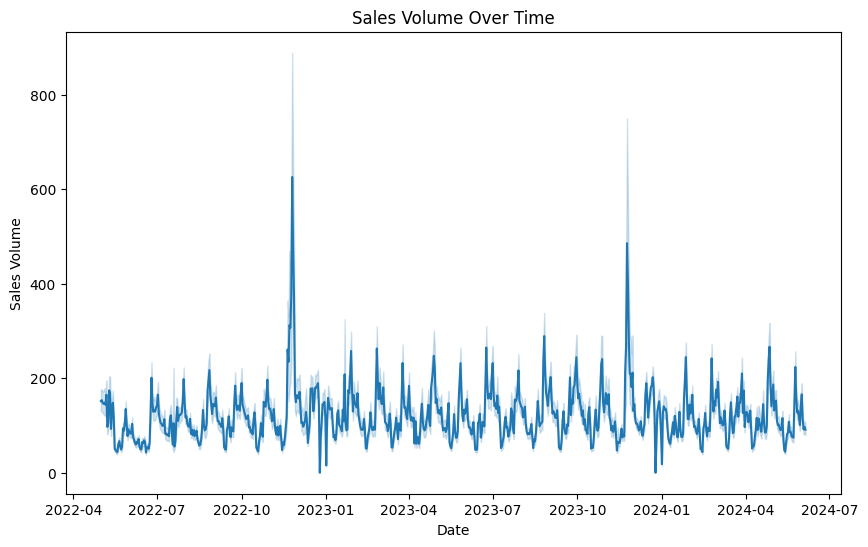

In [70]:
# Plot sales volume over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='sales_date', y='volume', data=df)
plt.title('Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.show()

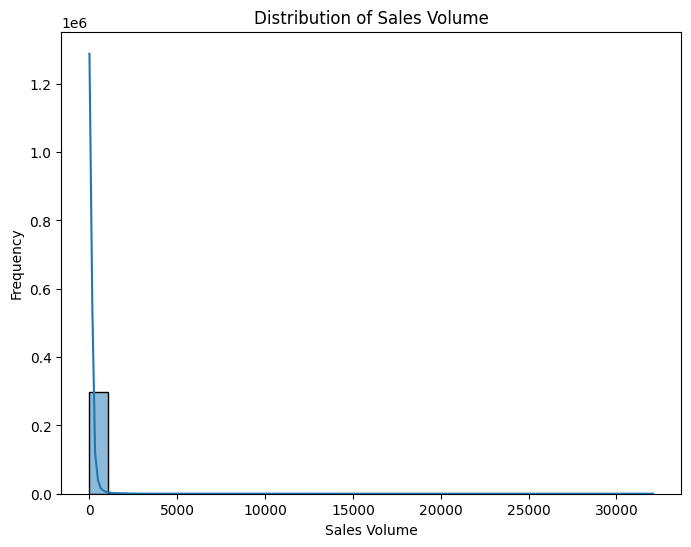

In [71]:
# Distribution of sales volume
plt.figure(figsize=(8, 6))
sns.histplot(df['volume'], bins=30, kde=True)
plt.title('Distribution of Sales Volume')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()


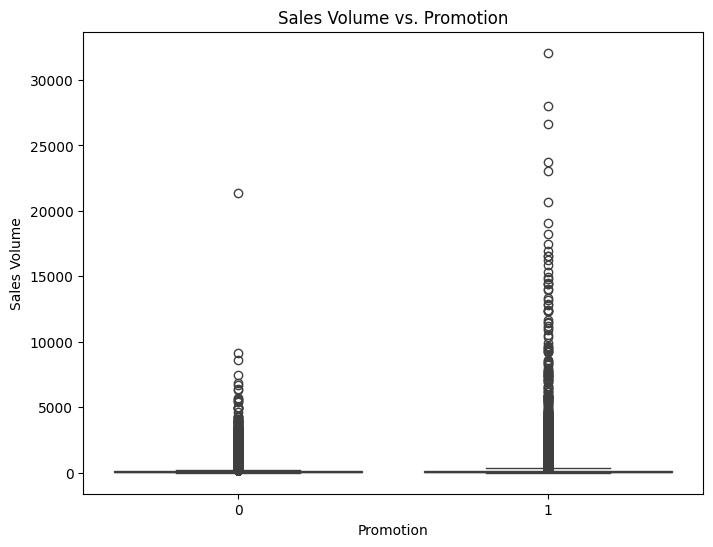

Average sales volume by promotion:
is_promo
0     96.271113
1    143.403851
Name: volume, dtype: float64


In [72]:
# Sales volume vs. promotion
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_promo', y='volume', data=df)
plt.title('Sales Volume vs. Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by promotion
print("Average sales volume by promotion:")
print(df.groupby('is_promo')['volume'].mean())


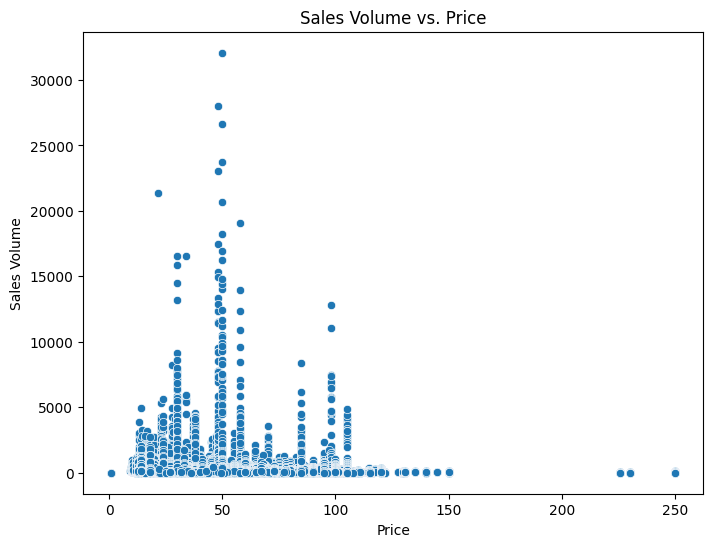

Correlation between price and sales volume:
             rsp    volume
rsp     1.000000 -0.120048
volume -0.120048  1.000000


In [73]:
# Sales volume vs. price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rsp', y='volume', data=df)
plt.title('Sales Volume vs. Price')
plt.xlabel('Price')
plt.ylabel('Sales Volume')
plt.show()

# Correlation between price and sales volume
print("Correlation between price and sales volume:")
print(df[['rsp', 'volume']].corr())


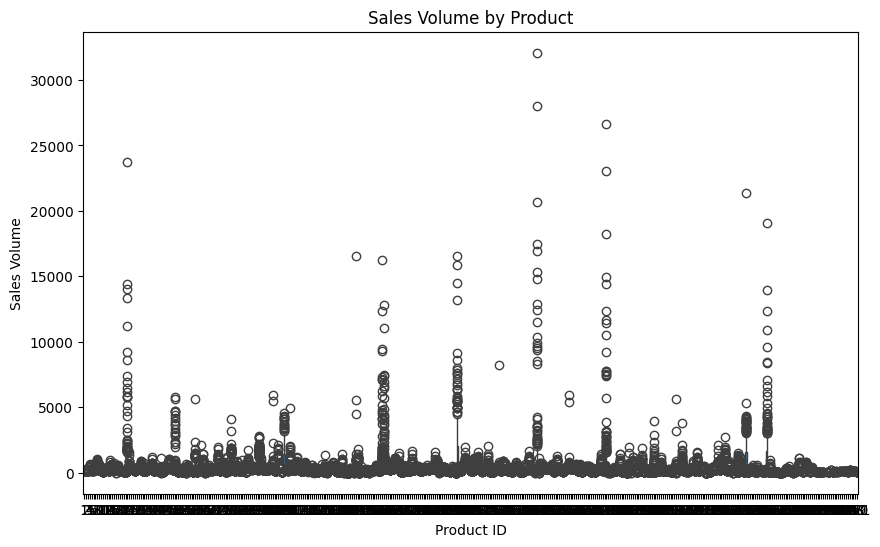

Average sales volume by product:
product_code
1       76.757497
2       64.371578
3       56.235984
4      171.852673
5       66.667536
          ...    
407     82.383764
408     58.664207
409     44.660517
410     59.051661
411     20.435424
Name: volume, Length: 411, dtype: float64


In [74]:
# Sales volume by product
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_code', y='volume', data=df)
plt.title('Sales Volume by Product')
plt.xlabel('Product ID')
plt.ylabel('Sales Volume')
plt.show()

# Average sales volume by product
print("Average sales volume by product:")
print(df.groupby('product_code')['volume'].mean())


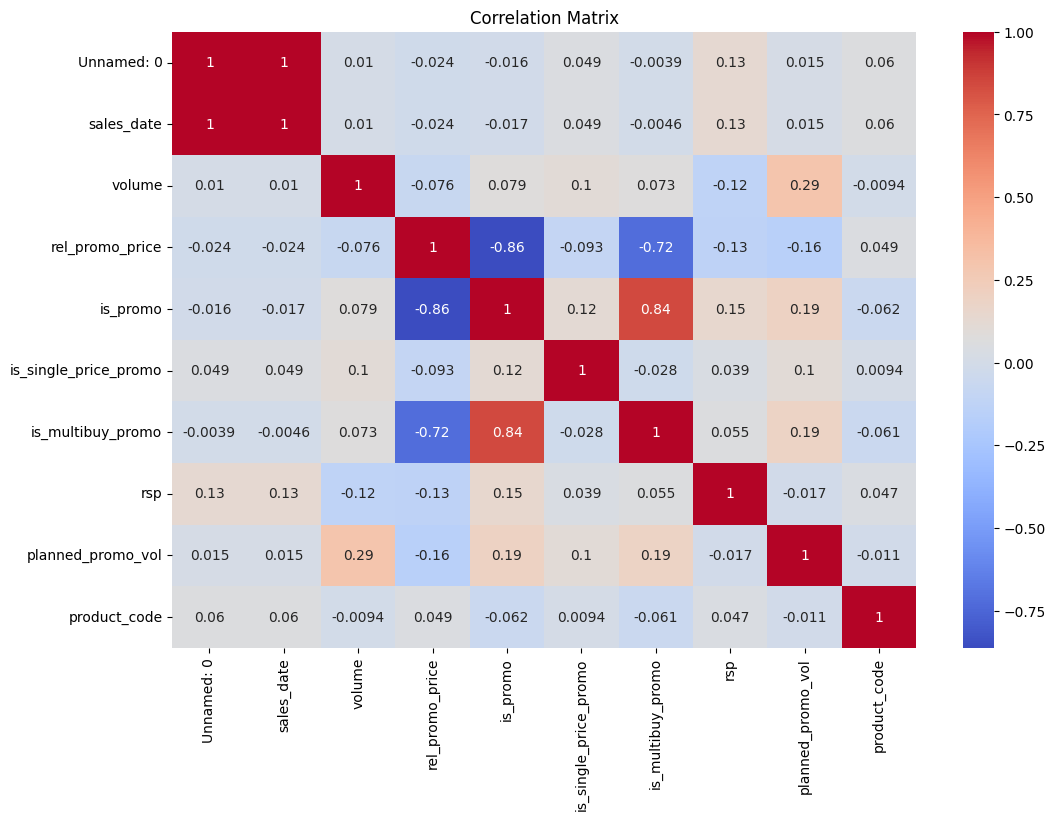

In [75]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Engineering
********************************
Feature engineering involves creating new features or modifying existing ones to improve the model's performance.


In [76]:
# Extract additional time features
df['year'] = df['sales_date'].dt.year
df['month'] = df['sales_date'].dt.month
df['day'] = df['sales_date'].dt.day
df['dayofweek'] = df['sales_date'].dt.dayofweek
df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1,2022,5,1,6
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2,2022,5,1,6
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3,2022,5,1,6
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4,2022,5,1,6
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5,2022,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,0.8333,1,0,1,77.9900,107.7537,156,2024,6,5,2
300764,300764,2024-06-05,26.0,1.0000,0,0,0,77.4567,0.0000,147,2024,6,5,2
300765,300765,2024-06-05,71.0,1.0000,0,0,0,18.0111,0.0000,85,2024,6,5,2
300766,300766,2024-06-05,0.0,1.0000,0,0,0,35.9900,0.0000,98,2024,6,5,2


In [24]:
# Drop the original date column
#df.drop('sales_date', axis=1, inplace=True)
#df

In [77]:

# Extract additional features
df['weekofyear'] = df['sales_date'].dt.isocalendar().week
df['is_weekend'] = df['sales_date'].dt.dayofweek >= 5

# Define special days
def is_black_friday(date):
    if date.month == 11 and (23 <= date.day <= 29) and date.weekday() == 4:
        return 1
    return 0

def is_christmas(date):
    return 1 if date.month == 12 and date.day == 25 else 0

def is_new_year(date):
    return 1 if date.month == 1 and date.day == 1 else 0

df['is_black_friday'] = df['sales_date'].apply(is_black_friday)
df['is_christmas'] = df['sales_date'].apply(is_christmas)
df['is_new_year'] = df['sales_date'].apply(is_new_year)

In [78]:
df.head(20)

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,weekofyear,is_weekend,is_black_friday,is_christmas,is_new_year
0,0,2022-05-01,61.0,1.0000,0,0,0,32.9500,0.0000,1,2022,5,1,6,17,True,0,0,0
1,1,2022-05-01,102.0,1.0000,0,0,0,40.1204,0.0000,2,2022,5,1,6,17,True,0,0,0
2,2,2022-05-01,52.0,1.0000,0,0,0,32.7825,0.0000,3,2022,5,1,6,17,True,0,0,0
3,3,2022-05-01,309.0,0.9091,1,0,0,41.3318,0.0001,4,2022,5,1,6,17,True,0,0,0
4,4,2022-05-01,106.0,0.9091,1,0,0,44.6441,0.0001,5,2022,5,1,6,17,True,0,0,0
5,5,2022-05-01,102.0,1.0000,0,0,0,29.9750,0.0000,6,2022,5,1,6,17,True,0,0,0
6,6,2022-05-01,162.0,0.9091,1,0,1,17.6530,0.3471,7,2022,5,1,6,17,True,0,0,0
7,7,2022-05-01,241.0,1.0000,0,0,0,18.9579,0.0000,8,2022,5,1,6,17,True,0,0,0
8,8,2022-05-01,79.0,1.0000,0,0,0,58.8976,0.0000,9,2022,5,1,6,17,True,0,0,0
9,9,2022-05-01,71.0,1.0000,0,0,0,21.6518,0.0000,10,2022,5,1,6,17,True,0,0,0


## 6. Data Preparation
********************************

#### 6.1 Split into Train and Test Set

In [79]:
def split_time_series(df, prediction_length):
    """
    Function to split off a df of time series into time series, where the second time series
    includes the last `prediction_length` time steps.
    """
    # Create an empty dataframe for train and validation sets
    train_df = pd.DataFrame()
    validation_df = pd.DataFrame()

    # Group by the time series identifier
    grouped = df.groupby(time_series_id_col)

    # Iterate over each group (i.e., each individual time series)
    for item_id, group in grouped:
        # Sort the group by date if it's not already sorted
        group = group.sort_index()

        # Define the split point
        split_point = len(group) - prediction_length

        # Split the data into training and validation sets
        train_group = group.iloc[:split_point]
        validation_group = group

        # Append to the respective dataframes
        train_df = pd.concat([train_df, train_group])
        validation_df = pd.concat([validation_df, validation_group])

    return train_df, validation_df

train_df, test_df = split_time_series(df, prediction_length)

In [80]:
train_df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,weekofyear,is_weekend,is_black_friday,is_christmas,is_new_year
0,0,2022-05-01,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,1,6,17,True,0,0,0
599,599,2022-05-02,61.0,1.0,0,0,0,32.9500,0.0,1,2022,5,2,0,18,False,0,0,0
843,843,2022-05-03,60.0,1.0,0,0,0,32.9500,0.0,1,2022,5,3,1,18,False,0,0,0
1409,1409,2022-05-04,61.0,1.0,0,0,0,32.9656,0.0,1,2022,5,4,2,18,False,0,0,0
1485,1485,2022-05-05,49.0,1.0,0,0,0,32.9656,0.0,1,2022,5,5,3,18,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287531,287531,2024-05-04,15.0,1.0,0,0,0,16.0679,0.0,411,2024,5,4,5,18,True,0,0,0
287796,287796,2024-05-05,10.0,1.0,0,0,0,16.0679,0.0,411,2024,5,5,6,18,True,0,0,0
288185,288185,2024-05-06,12.0,1.0,0,0,0,16.0679,0.0,411,2024,5,6,0,19,False,0,0,0
288598,288598,2024-05-07,14.0,1.0,0,0,0,16.0679,0.0,411,2024,5,7,1,19,False,0,0,0


In [81]:
len(test_df)

300768

#### 6.2. Scaling and Normalization

In [82]:
# Encode categorical variables (if any)
# For simplicity, we'll use one-hot encoding
#df = pd.get_dummies(df, columns=['product_code'], drop_first=True)
#df

# Scale numerical features
scaler = StandardScaler()
df[['rel_promo_price', 'rsp', 'planned_promo_vol']] = scaler.fit_transform(df[['rel_promo_price', 'rsp', 'planned_promo_vol']])
df

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,weekofyear,is_weekend,is_black_friday,is_christmas,is_new_year
0,0,2022-05-01,61.0,0.958724,0,0,0,-0.720327,-0.201879,1,2022,5,1,6,17,True,0,0,0
1,1,2022-05-01,102.0,0.958724,0,0,0,-0.481447,-0.201879,2,2022,5,1,6,17,True,0,0,0
2,2,2022-05-01,52.0,0.958724,0,0,0,-0.725907,-0.201879,3,2022,5,1,6,17,True,0,0,0
3,3,2022-05-01,309.0,0.266256,1,0,0,-0.441090,-0.201879,4,2022,5,1,6,17,True,0,0,0
4,4,2022-05-01,106.0,0.266256,1,0,0,-0.330741,-0.201879,5,2022,5,1,6,17,True,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300763,300763,2024-06-05,63.0,-0.311181,1,0,1,0.780168,0.023878,156,2024,6,5,2,23,False,0,0,0
300764,300764,2024-06-05,26.0,0.958724,0,0,0,0.762401,-0.201879,147,2024,6,5,2,23,False,0,0,0
300765,300765,2024-06-05,71.0,0.958724,0,0,0,-1.218012,-0.201879,85,2024,6,5,2,23,False,0,0,0
300766,300766,2024-06-05,0.0,0.958724,0,0,0,-0.619050,-0.201879,98,2024,6,5,2,23,False,0,0,0


## 7. Model Development
********************************

#### 7.1. Model Training
We will train a simple feedforward neural network to predict future sales.



In [83]:
def train_ffnn_predictor(df):
    """
    A very basic feed forward predictor using GluonTS with a training and validation set.
    """
    df = df.copy()
    df.set_index(date_col, inplace=True) # GluonTS wants the timestamp to be the index

    # Split the training data into training and validation sets
    train_df, val_df = split_time_series(df, prediction_length)
    # Create the Pandas datasets
    train_ds = PandasDataset.from_long_dataframe(train_df,
                                                target=target_col,
                                                item_id=time_series_id_col,
                                                freq=freq)

    val_ds = PandasDataset.from_long_dataframe(val_df,
                                                target=target_col,
                                                item_id=time_series_id_col,
                                                freq=freq)

    # Train a feed forward estimator
    estimator = SimpleFeedForwardEstimator(
        num_hidden_dimensions=[10],
        prediction_length=prediction_length,
        context_length=100,
        trainer=Trainer(ctx="cpu", epochs=10, learning_rate=1e-3, num_batches_per_epoch=100),
    )
    predictor = estimator.train(training_data=train_ds, validation_data=val_ds)
    return predictor

ffnn_predictor = train_ffnn_predictor(train_df)


100%|██████████| 100/100 [00:03<00:00, 25.46it/s, epoch=1/10, avg_epoch_loss=5.84]

13it [00:00, 27.30it/s, epoch=1/10, validation_avg_epoch_loss=5.42]

100%|██████████| 100/100 [00:03<00:00, 26.40it/s, epoch=2/10, avg_epoch_loss=5.45]

13it [00:00, 29.92it/s, epoch=2/10, validation_avg_epoch_loss=5.33]

100%|██████████| 100/100 [00:05<00:00, 19.89it/s, epoch=3/10, avg_epoch_loss=5.34]

13it [00:00, 32.01it/s, epoch=3/10, validation_avg_epoch_loss=5.26]

100%|██████████| 100/100 [00:03<00:00, 28.23it/s, epoch=4/10, avg_epoch_loss=5.28]

13it [00:00, 30.87it/s, epoch=4/10, validation_avg_epoch_loss=5.22]

100%|██████████| 100/100 [00:03<00:00, 28.63it/s, epoch=5/10, avg_epoch_loss=5.25]

13it [00:00, 30.94it/s, epoch=5/10, validation_avg_epoch_loss=5.22]

100%|██████████| 100/100 [00:04<00:00, 21.31it/s, epoch=6/10, avg_epoch_loss=5.19]

13it [00:00, 21.00it/s, epoch=6/10, validation_avg_epoch_loss=5.19]

100%|██████████| 100/100 [00:03<00:00, 26.43it/s, epoch=7/10, avg_epoch_loss=5.22

#### 7.2. Model Prediction

Using the trained model to make predictions on the test dataset.

In [84]:
def make_predictions(predictor, df, feature_columns=[]):
    """
    Make predictions with a GluonTS predictor and return them as a df.
    """
    df = df.copy()
    df = df.fillna(0) # Replace any NaNs with 0
    df.set_index(date_col, inplace=True) # GluonTS wants the timestamp to be the index
    dataset = PandasDataset.from_long_dataframe(df,
                                                target=target_col,
                                                item_id=time_series_id_col,
                                                freq=freq,
                                                feat_dynamic_real=feature_columns)

    forecast_it, _ = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)

    # Initialize a list to hold all the records before converting to a DataFrame
    records = []
    for forecast in forecasts:
        item_id = forecast.item_id
        start_timestamp = forecast.start_date.start_time

        # GluonTS does probabilistic forecasting with a number of samples
        # Calculate mean targets across all samples for each date position
        mean_targets = forecast.samples.mean(axis=0)
        for i, target in enumerate(mean_targets):
            # Calculate what the timestamp should be for each predicted target
            timestamp = start_timestamp + i * pd.to_timedelta(freq)
            # Store the prediction as a record
            records.append({date_col: timestamp, time_series_id_col: item_id, target_col: target})

    # Convert the predictions from a list of records into a DataFrame
    preds_df = pd.DataFrame(records)
    preds_df.set_index(date_col, inplace=True)
    return preds_df


In [46]:

output_preds_path = "my_predictions.csv"
preds_df = make_predictions(ffnn_predictor, test_df)
preds_df.to_csv(output_preds_path)

#### 7.3. Model Evaluation

We compute the error between the forecasts and the actual sales to evaluate our model's performance. For this we main use overall relative error bias, the metric for the hackathon should probably be a weighted combination like `(1 - rE - 0.5*abs(rB)
)*100`.

In [85]:
def compute_error(actuals_path, preds_path):
    """
    Computes the relative error and relative bias from csv files of predictions and actual targets.
    """
    # Read predicted and actuals from their respective files if not already provided
    actuals_df = pd.read_csv(actuals_path, parse_dates=[date_col])
    preds_df = pd.read_csv(preds_path, parse_dates=[date_col])

    # Rename 'target' column to add suffix for 'preds' and 'actuals' respectively
    actuals_df.rename(columns={target_col: f'{target_col}_actuals'}, inplace=True)
    preds_df.rename(columns={target_col: f'{target_col}_preds'}, inplace=True)

    # Merge the two dataframes on the timestamp column and the time series identifier column
    df = pd.merge(actuals_df, preds_df, on=[date_col, time_series_id_col])

    actual_var = target_col + '_actuals'
    pred_var = target_col +'_preds'
    measure_level = [time_series_id_col, date_col]

    # Drop all unecessary columns
    keep_vars = list(set(measure_level + [actual_var, pred_var]))
    df_filtered = df.dropna(subset=[actual_var])[keep_vars]
    df_filtered.rename(columns={actual_var: 'A', pred_var: 'P'}, inplace=True)

    # Group by measure_level and aggregate A and P
    grouped = df_filtered.groupby(measure_level, observed=False).agg(A=('A', 'sum'), P=('P', 'sum'))

    # Calculate the errors initially at measure_level (not the absolute sum yet)
    grouped['E'] = (grouped['A'] - grouped['P']).abs()

    # Aggregate all data to one row
    grouped = grouped.sum()

    # Calculate relative error (rE) and relative bias (rB)
    grouped['rE'] = grouped['E'] / grouped['A']
    grouped['rB'] = (grouped['P'] - grouped['A']) / grouped['A']
    return grouped



In [48]:
output_preds_path = "my_predictions.csv"
report = compute_error(data_path, output_preds_path)
print("Error Report:")
print(report)

forecast_acc = (1 - (report.rE)) * 100
forecast_bias = report.rB * 100
acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
print(f"Forecast Bias is: {forecast_bias:.2f}%")
print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

Error Report:
A     1.199319e+06
P     1.322433e+06
E     5.546608e+05
rE    4.624798e-01
rB    1.026537e-01
dtype: float64
Forecast Accuracy is: 53.75%
Forecast Bias is: 10.27%
Bias-weighted Accuracy: 48.62%


#### 7.4. DeepAR-based forecast

The simple feed forward predictor used previously is unable to make use of any of our features for prediction, making its usefulness limited. GluonTS provides a host of different deep-learning forecasting models which you can try out to see which works best, you can read about each one [here](https://ts.gluon.ai/stable/getting_started/models.html).

In this example, we use the DeepAR probabilistic forecasting model which you can read about [here](https://https://www.sciencedirect.com/science/article/pii/S0169207019301888?via%3Dihub).

In [89]:
# from gluonts.torch import DeepAREstimator

# def train_deep_ar_predictor(df, feature_columns):
#     """
#     A more advance model able to make use of features.
#     """
#     df = df.copy()
#     df.set_index(date_col, inplace=True) # GluonTS wants the timestamp to be the index
#     df = df.fillna(0) # Replace any NaNs with 0

#     # Split the training data into training and validation sets
#     train_df, val_df = split_time_series(df, prediction_length)
#     # Create the Pandas datasets
#     train_ds = PandasDataset.from_long_dataframe(train_df,
#                                                 target=target_col,
#                                                 item_id=time_series_id_col,
#                                                 freq=freq,
#                                                 feat_dynamic_real=feature_columns)

#     val_ds = PandasDataset.from_long_dataframe(val_df,
#                                                 target=target_col,
#                                                 item_id=time_series_id_col,
#                                                 freq=freq,
#                                                 feat_dynamic_real=feature_columns)

#     # Train a feed forward estimator
#     estimator = DeepAREstimator(
#         prediction_length=prediction_length,
#         freq=freq,
#         num_feat_dynamic_real=len(feature_columns),
#         trainer_kwargs={"max_epochs": 50} #30}
#     )
#     predictor = estimator.train(training_data=train_ds, validation_data=val_ds)
#     return predictor

# # Define which features to use and train
# #ales_date 	volume 	rel_promo_price 	is_promo 	is_single_price_promo 	is_multibuy_promo 	rsp 	planned_promo_vol 	product_code 	year 	month 	day 	dayofweek
# #feature_columns=['is_promo', 'rel_promo_price', 'planned_promo_vol', 'rsp']
# #feature_columns=['rel_promo_price', 	'is_promo', 	'is_single_price_promo', 	'is_multibuy_promo', 	'rsp', 	'planned_promo_vol', 	'year', 	'month', 	'day', 	'dayofweek', 	'weekofyear', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
# #feature_columns=['rel_promo_price', 	'is_promo', 'month', 	'day', 	'dayofweek', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
# feature_columns=['rel_promo_price', 	'is_promo',	'day', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
# deep_ar_predictor = train_deep_ar_predictor(train_df, feature_columns)

# # Make predictions
# output_preds_path = "my_deep_ar_predictions3.csv"
# preds_df = make_predictions(deep_ar_predictor, test_df, feature_columns)
# preds_df.to_csv(output_preds_path)

# # Evaluate
# report = compute_error(data_path, output_preds_path)
# print("DeepAR Error Report:")
# print(report)

# forecast_acc = (1 - (report.rE)) * 100
# forecast_bias = report.rB * 100
# acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
# print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
# print(f"Forecast Bias is: {forecast_bias:.2f}%")
# print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

KeyboardInterrupt: 

In [ ]:
# Make predictions
output_preds_path = "my_deep_ar_predictions2.csv"
#preds_df = make_predictions(deep_ar_predictor, test_df, feature_columns)
#preds_df.to_csv(output_preds_path)

# Evaluate
report = compute_error(data_path, output_preds_path)
print("DeepAR Error Report:")
print(report)

forecast_acc = (1 - (report.rE)) * 100
forecast_bias = report.rB * 100
acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
print(f"Forecast Bias is: {forecast_bias:.2f}%")
print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

# MY MODEL #

You need to run the feature engineering cell as well

In [86]:
from gluonts.torch import DeepAREstimator

def train_deep_ar_predictor(df, feature_columns):
    """
    A more advance model able to make use of features.
    """
    df = df.copy()
    df.set_index(date_col, inplace=True) # GluonTS wants the timestamp to be the index
    df = df.fillna(0) # Replace any NaNs with 0

    # Split the training data into training and validation sets
    train_df, val_df = split_time_series(df, prediction_length)
    # Create the Pandas datasets
    train_ds = PandasDataset.from_long_dataframe(train_df,
                                                target=target_col,
                                                item_id=time_series_id_col,
                                                freq=freq,
                                                feat_dynamic_real=feature_columns)

    val_ds = PandasDataset.from_long_dataframe(val_df,
                                                target=target_col,
                                                item_id=time_series_id_col,
                                                freq=freq,
                                                feat_dynamic_real=feature_columns)

    # Train a feed forward estimator
    estimator = DeepAREstimator(
        prediction_length=prediction_length,
        freq=freq,
        num_feat_dynamic_real=len(feature_columns),
        trainer_kwargs={"max_epochs": 50} #30}
    )
    predictor = estimator.train(training_data=train_ds, validation_data=val_ds)
    return predictor

# Define which features to use and train
#ales_date 	volume 	rel_promo_price 	is_promo 	is_single_price_promo 	is_multibuy_promo 	rsp 	planned_promo_vol 	product_code 	year 	month 	day 	dayofweek
#feature_columns=['is_promo', 'rel_promo_price', 'planned_promo_vol', 'rsp']
#feature_columns=['rel_promo_price', 	'is_promo', 	'is_single_price_promo', 	'is_multibuy_promo', 	'rsp', 	'planned_promo_vol', 	'year', 	'month', 	'day', 	'dayofweek', 	'weekofyear', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
#feature_columns=['rel_promo_price', 	'is_promo', 'month', 	'day', 	'dayofweek', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
feature_columns=['rel_promo_price', 	'is_promo',	'day', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
deep_ar_predictor = train_deep_ar_predictor(train_df, feature_columns)

# Make predictions
output_preds_path = "FINAL_RESULTS.csv"
preds_df = make_predictions(deep_ar_predictor, test_df, feature_columns)
preds_df.to_csv(output_preds_path)

# Evaluate
report = compute_error(data_path, output_preds_path)
print("DeepAR Error Report:")
print(report)

forecast_acc = (1 - (report.rE)) * 100
forecast_bias = report.rB * 100
acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
print(f"Forecast Bias is: {forecast_bias:.2f}%")
print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type        | Params | In sizes                                                           | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.0 K | [[1, 1], [1, 1], [1, 1120, 11], [1, 1120], [1, 1120], [1, 28, 11]] | [1, 100, 28]
--------------------------------------------------------------------------------------------------------------------------
27.0 K    Trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'val_loss' reached 4.98814 (best 4.98814), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached 4.98814 (best 4.98814), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 100: 'val_loss' reached 4.67324 (best 4.67324), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' reached 4.67324 (best 4.67324), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 150: 'val_loss' reached 4.53555 (best 4.53555), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' reached 4.53555 (best 4.53555), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 200: 'val_loss' reached 4.46738 (best 4.46738), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' reached 4.46738 (best 4.46738), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 250: 'val_loss' reached 4.42449 (best 4.42449), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 250: 'val_loss' reached 4.42449 (best 4.42449), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 300: 'val_loss' reached 4.39169 (best 4.39169), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 300: 'val_loss' reached 4.39169 (best 4.39169), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 350: 'val_loss' reached 4.34777 (best 4.34777), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=350.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 350: 'val_loss' reached 4.34777 (best 4.34777), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 450: 'val_loss' reached 4.32660 (best 4.32660), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=450.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 450: 'val_loss' reached 4.32660 (best 4.32660), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 500: 'val_loss' reached 4.31489 (best 4.31489), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 500: 'val_loss' reached 4.31489 (best 4.31489), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 550: 'val_loss' reached 4.30709 (best 4.30709), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=10-step=550.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 550: 'val_loss' reached 4.30709 (best 4.30709), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=10-step=550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 750: 'val_loss' reached 4.30181 (best 4.30181), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=14-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 750: 'val_loss' reached 4.30181 (best 4.30181), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 900: 'val_loss' reached 4.29438 (best 4.29438), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=17-step=900.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 900: 'val_loss' reached 4.29438 (best 4.29438), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=17-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 950: 'val_loss' reached 4.27886 (best 4.27886), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=18-step=950.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 950: 'val_loss' reached 4.27886 (best 4.27886), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 1000: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 1050: 'val_loss' reached 4.26616 (best 4.26616), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=20-step=1050.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 1050: 'val_loss' reached 4.26616 (best 4.26616), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 1100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 1150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 1200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 1250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 1300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 1350: 'val_loss' reached 4.25700 (best 4.25700), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=26-step=1350.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 1350: 'val_loss' reached 4.25700 (best 4.25700), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=26-step=1350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 1400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 28, global step 1450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 1500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 30, global step 1550: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 31, global step 1600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 1600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 32, global step 1650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 33, global step 1700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 34, global step 1750: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 35, global step 1800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 36, global step 1850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 1850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 37, global step 1900: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 38, global step 1950: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 39, global step 2000: 'val_loss' reached 4.25396 (best 4.25396), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=39-step=2000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 2000: 'val_loss' reached 4.25396 (best 4.25396), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=39-step=2000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 40, global step 2050: 'val_loss' reached 4.24985 (best 4.24985), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=40-step=2050.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 2050: 'val_loss' reached 4.24985 (best 4.24985), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=40-step=2050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 41, global step 2100: 'val_loss' reached 4.23674 (best 4.23674), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=41-step=2100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 2100: 'val_loss' reached 4.23674 (best 4.23674), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=41-step=2100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 42, global step 2150: 'val_loss' reached 4.22945 (best 4.22945), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=42-step=2150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 2150: 'val_loss' reached 4.22945 (best 4.22945), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=42-step=2150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 43, global step 2200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 44, global step 2250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 2250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 45, global step 2300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 2300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 46, global step 2350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 2350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 47, global step 2400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 48, global step 2450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 2450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


DeepAR Error Report:
A     1.199319e+06
P     1.183889e+06
E     3.942289e+05
rE    3.287106e-01
rB   -1.286557e-02
dtype: float64
Forecast Accuracy is: 67.13%
Forecast Bias is: -1.29%
Bias-weighted Accuracy: 66.49%


In [88]:
# # Evaluate
# output_preds_path = "/content/my_deep_ar_predictions5.csv"
# report = compute_error(data_path, output_preds_path)
# print("DeepAR Error Report:")
# print(report)

# forecast_acc = (1 - (report.rE)) * 100
# forecast_bias = report.rB * 100
# acc_bias = forecast_acc - 0.5 * abs(forecast_bias)
# print(f"Forecast Accuracy is: {forecast_acc:.2f}%")
# print(f"Forecast Bias is: {forecast_bias:.2f}%")
# print(f"Bias-weighted Accuracy: {acc_bias:.2f}%")

DeepAR Error Report:
A     1.199319e+06
P     1.122276e+06
E     3.798714e+05
rE    3.167393e-01
rB   -6.423875e-02
dtype: float64
Forecast Accuracy is: 68.33%
Forecast Bias is: -6.42%
Bias-weighted Accuracy: 65.11%


#### Your Model THIS DID NOT WORK


In [ ]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

In [ ]:
# # train a xgboost
# features = ['rel_promo_price', 	'is_promo', 	'is_single_price_promo', 	'is_multibuy_promo', 	'rsp', 	'planned_promo_vol', 	'year', 	'month', 	'day', 	'dayofweek', 	'weekofyear', 	'is_weekend', 	'is_black_friday', 	'is_christmas', 	'is_new_year']
# X = df[features]
# y = df['volume']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# # Initialize DMatrix for XGBoost
# train_data = xgb.DMatrix(X_train, label=y_train)
# test_data = xgb.DMatrix(X_test, label=y_test)

# # Define parameters
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.1,
#     'max_depth': 6
# }

# # Train the model
# evals = [(train_data, 'train'), (test_data, 'test')]
# model = xgb.train(params, train_data, num_boost_round=100, evals=evals, early_stopping_rounds=10)

# # Predict
# y_pred = model.predict(test_data)

[0]	train-rmse:307.16974	test-rmse:181.70922
[1]	train-rmse:297.31498	test-rmse:178.63061
[2]	train-rmse:288.90180	test-rmse:176.61566
[3]	train-rmse:280.84184	test-rmse:177.49258
[4]	train-rmse:274.68376	test-rmse:176.11877
[5]	train-rmse:269.32888	test-rmse:176.97518
[6]	train-rmse:263.87453	test-rmse:175.24165
[7]	train-rmse:259.43201	test-rmse:175.25309
[8]	train-rmse:256.05157	test-rmse:176.50420
[9]	train-rmse:249.83072	test-rmse:175.98803
[10]	train-rmse:246.45973	test-rmse:175.88130
[11]	train-rmse:244.01305	test-rmse:176.30216
[12]	train-rmse:241.42397	test-rmse:176.60015
[13]	train-rmse:239.39967	test-rmse:177.13211
[14]	train-rmse:237.85858	test-rmse:178.40590
[15]	train-rmse:236.10596	test-rmse:178.79566
[16]	train-rmse:234.33789	test-rmse:178.86494


In [ ]:
# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'RMSE: {rmse}')

RMSE: 178.86494180658906


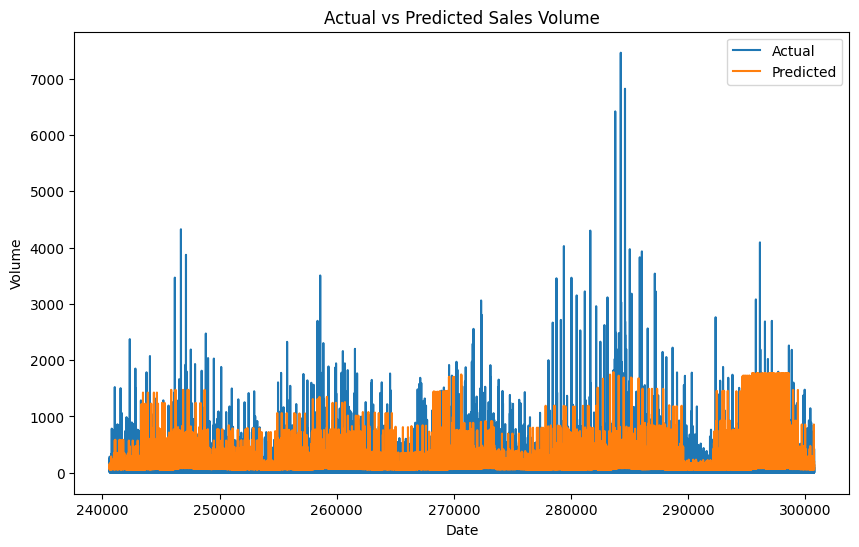

In [ ]:
# import matplotlib.pyplot as plt

# # Plot predictions vs actual
# plt.figure(figsize=(10, 6))
# plt.plot(y_test.index, y_test, label='Actual')
# plt.plot(y_test.index, y_pred, label='Predicted')
# plt.legend()
# plt.title('Actual vs Predicted Sales Volume')
# plt.xlabel('Date')
# plt.ylabel('Volume')
# plt.show()


In [ ]:
# # Predict
# test_data2 = xgb.DMatrix(X, label=y)
# y_pred_final = model.predict(test_data2)

In [ ]:
# df.head(10)

,Unnamed: 0,sales_date,volume,rel_promo_price,is_promo,is_single_price_promo,is_multibuy_promo,rsp,planned_promo_vol,product_code,year,month,day,dayofweek,weekofyear,is_weekend,is_black_friday,is_christmas,is_new_year
0,0,2022-05-01,61.0,0.958724,0,0,0,-0.720327,-0.201879,1,2022,5,1,6,17,True,0,0,0
1,1,2022-05-01,102.0,0.958724,0,0,0,-0.481447,-0.201879,2,2022,5,1,6,17,True,0,0,0
2,2,2022-05-01,52.0,0.958724,0,0,0,-0.725907,-0.201879,3,2022,5,1,6,17,True,0,0,0
3,3,2022-05-01,309.0,0.266256,1,0,0,-0.441090,-0.201879,4,2022,5,1,6,17,True,0,0,0
4,4,2022-05-01,106.0,0.266256,1,0,0,-0.330741,-0.201879,5,2022,5,1,6,17,True,0,0,0
5,5,2022-05-01,102.0,0.958724,0,0,0,-0.819438,-0.201879,6,2022,5,1,6,17,True,0,0,0
6,6,2022-05-01,162.0,0.266256,1,0,1,-1.229942,-0.201152,7,2022,5,1,6,17,True,0,0,0
7,7,2022-05-01,241.0,0.958724,0,0,0,-1.186470,-0.201879,8,2022,5,1,6,17,True,0,0,0
8,8,2022-05-01,79.0,0.958724,0,0,0,0.144110,-0.201879,9,2022,5,1,6,17,True,0,0,0
9,9,2022-05-01,71.0,0.958724,0,0,0,-1.096723,-0.201879,10,2022,5,1,6,17,True,0,0,0


In [ ]:
#https://www.linkedin.com/pulse/how-predict-price-using-scikit-learn-step-by-step-approach-hassan


#### 7.4 Hyperparameter Tuning (optional, for more complex models)

Hyperparameter tuning involves searching for the best combination of parameters to improve the model's performance.


## 9. Submission
********************************
Ensure your notebook runs end-to-end without errors. Save your notebook and required dependencies in a requirements.txt file. Submit your notebook to Zindi for automated evaluation.


In [ ]:
# Save the model (if required)


print("Notebook is ready for submission!")
